# Лабораторная 4.
Выполнила Карасева Екатерина М33351.

In [17]:
import pandas as pd
import numpy as np

from scipy import stats
import statistics as st

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

Обучите один из алгоритмов классификации из библиотеки sklearn. Объяснять принцип работы классификатора в этой лабораторной не требуется

1. Выберите один из датасетов первой лабораторной
    * выбран датасет [Anime dataset](https://www.kaggle.com/thunderz/anime-dataset?select=user_data.csv) - данные о просмотре аниме пользователями с сайта myAnimeList

In [18]:
db = pd.read_csv('full_user_data.csv')
db = db.drop(db[db.gender == 'not specified'].index)
db = db.drop(db[db.mean_score == 0].index)
db = db.drop(db[db.completed == 0].index)
db = db.drop(db[db.days_watched == 0].index)
# для того что бы mean_score был нормальным
db = db.drop(db[db.mean_score <= 5].index)
db = db.drop(db[db.mean_score >= 10].index)
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1653 entries, 1 to 2193
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1653 non-null   object 
 1   planning          1653 non-null   object 
 2   watched           1653 non-null   object 
 3   completed         1653 non-null   int64  
 4   days_watched      1653 non-null   float64
 5   dropped           1653 non-null   int64  
 6   episodes_watched  1653 non-null   int64  
 7   mean_score        1653 non-null   float64
 8   on_hold           1653 non-null   int64  
 9   plan_to_watch     1653 non-null   int64  
 10  rewatched         1653 non-null   int64  
 11  total_entries     1653 non-null   int64  
 12  watching          1653 non-null   int64  
 13  birthday          1653 non-null   object 
 14  gender            1653 non-null   object 
 15  joined            1653 non-null   object 
 16  last_online       1653 non-null   object 


2. Найдите в данных признак, который будете предсказывать
    
    Если это категория, то у неё должно быть от 2 до 10 значений
    * выбранный признак - пол, имеет 3 значения (Male, Female, Non-Binary)

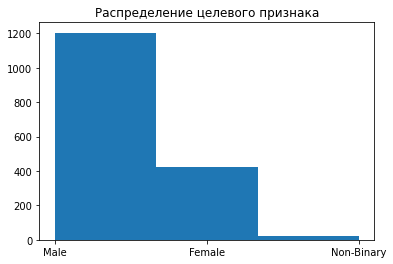

In [19]:
# Распределение целевого признака
plt.hist(db.gender, bins=db.gender.nunique())
plt.title('Распределение целевого признака')
plt.show()

3. Выделите признаки для предсказания
    
    Используйте от 2 до 5 количественных признаков для предсказания целевой переменной
    * выбранные количественные признаки - средняя оценка и количество просмотренных аниме и количество брошенных.

In [20]:
cdf = pd.DataFrame(db, columns=['completed', 'dropped', 'mean_score', 'gender'])
lab4df = cdf.drop(cdf[cdf['completed'] > 1000].index)
lab4df = lab4df.drop(lab4df[lab4df['dropped'] > 300].index)
lab4df.to_csv('lab4_user_data.csv', index_label=False)

4. Проверьте нормальность количественных признаков
    
    Используйте статистический тест из лекции. Если распределение является лог-нормальным, логарифмируйте его и проверьте на нормальность
    
    Как минимум 1 из признаков должен быть нормальным

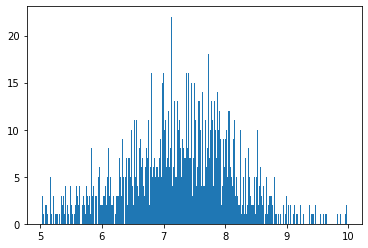

In [21]:
#mean_score
plt.hist(cdf.mean_score, bins=cdf.mean_score.nunique())
plt.show()

In [22]:
print(stats.normaltest(cdf.mean_score))
print(stats.normaltest(np.random.normal(0, 1, len(cdf.index))))

NormaltestResult(statistic=1.9364321421902737, pvalue=0.37975989884863537)
NormaltestResult(statistic=1.397504346483944, pvalue=0.4972053429914225)


In [23]:
def mll_test(array):
    mu, sigma = stats.norm.fit(array)
    distribution = stats.norm(loc=mu, scale=sigma)
    return st.mean(map(distribution.logpdf, array))

print(mll_test(cdf.mean_score))
print(mll_test(np.random.normal(0, 1, len(cdf.index))))

-1.303300615094145
-1.4041278895198752


In [24]:
#completed
print(stats.normaltest(cdf.completed))
print(stats.normaltest(np.random.normal(0, 1, len(cdf.index))))

NormaltestResult(statistic=2873.726357736894, pvalue=0.0)
NormaltestResult(statistic=3.9606971757240474, pvalue=0.13802111643831066)


In [25]:
print(mll_test(cdf.completed))
print(mll_test(np.random.normal(0, 1, len(cdf.index))))

-7.974887940253827
-1.4381728911068437


In [26]:
# dropped
print(stats.normaltest(cdf.dropped))
print(stats.normaltest(np.random.normal(0, 1, len(cdf.index))))

NormaltestResult(statistic=4646.631015195836, pvalue=0.0)
NormaltestResult(statistic=0.007229889543864321, pvalue=0.9963915812747854)


In [27]:
print(mll_test(cdf.dropped))
print(mll_test(np.random.normal(0, 1, len(cdf.index))))

-6.870749666684207
-1.4240788228345704


### Анализ

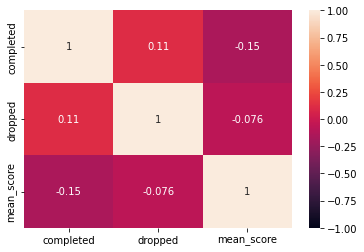

In [28]:
sns.heatmap(cdf.corr(), vmin=-1, vmax=1, annot=True);

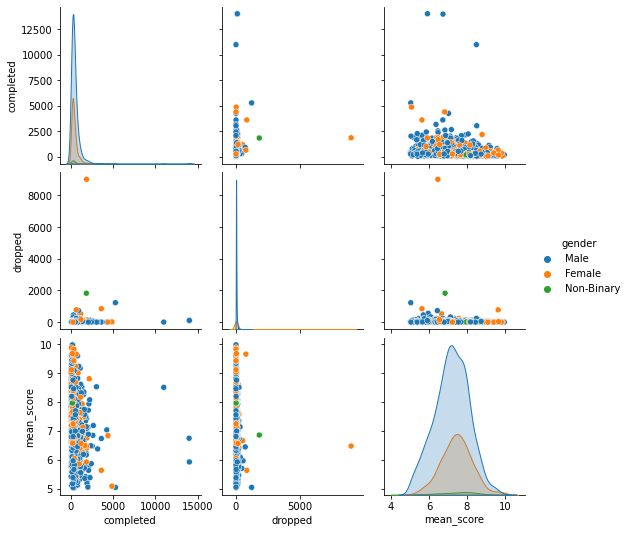

In [29]:
sns.pairplot(cdf, hue='gender');

### Обучение

In [30]:
x = cdf[['completed', 'dropped', 'mean_score']]
y = cdf['gender']

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, stratify=y, test_size=0.2)

knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

for clf in [knn_clf, svm_clf, forest_clf]:
    clf.fit(x_train, y_train)

5. Покажите качество предсказания модели с помощью метрик

In [31]:
knn_pred = knn_clf.predict(x_test)
svm_pred = svm_clf.predict(x_test)
forest_pred = forest_clf.predict(x_test)

knn_f1_score = f1_score(y_test, knn_pred, average='weighted')
svm_f1_score = f1_score(y_test, svm_pred, average='weighted')
forest_f1_score = f1_score(y_test, forest_pred, average='weighted')

leaderboard = sorted([
    ('KNN', knn_f1_score),
    ('SVC', svm_f1_score),
    ('Forest', forest_f1_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. Forest: 0.6285310019297091
2. SVC: 0.6135360108169776
3. KNN: 0.5999959225563632
